# Quantum Chemistry Example
## Putting Quantum Chemistry Hamiltonians on Quantum Hardware

<table><tr>
<td> <img src="chemistry1_SC24.png" alt="Drawing" style="width: 800px;"/> </td>
</tr></table>

In [1]:
!pip install openfermion==1.6.1 -q #forgot to add this in the image!

In [2]:
import openfermion
import openfermionpyscf
from openfermion.transforms import jordan_wigner, get_fermion_operator

import os
import timeit

import cudaq
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np

Need to pick a molecule (below is water), define the geometry (can find many equilibrium geometries here: https://cccbdb.nist.gov/expgeom1x.asp), and pick the basis set:

In [3]:
geometry = [('O', (0.1173, 0.0, 0.0)), ('H', (-0.4691, 0.7570, 0.0)),
            ('H', (-0.4691, -0.7570, 0.0))]
basis = 'sto3g' #let's use a very simple basis set to keep the number of qubits small
multiplicity = 1
charge = 0

Next we need to build the qubit Hamiltonian. We start by using pyscf to (1) do a Hartree-Fock (HF) calculation which solves for the molecular orbitals using the HF approximation (2) Computes one-electron and two-electron integrals, orbital energies, and other molecular properties (3) Saves the results back into the MolecularData object for further use (e.g., quantum calculations).

In [4]:
#solve the Hartree-Fock equations
molecule = openfermionpyscf.run_pyscf(
    openfermion.MolecularData(geometry, basis, multiplicity, charge))

In [5]:
molecular_hamiltonian = molecule.get_molecular_hamiltonian()
fermion_hamiltonian = get_fermion_operator(molecular_hamiltonian)

The above extracts the molecular Hamiltonian from the quantum chemistry calculation results stored in the molecule object and translates the molecular Hamiltonian into its fermionic operator form.. The form of the Hamiltonian is the following:
$
H = \sum_{p, q} h_{pq} a_p^\dagger a_q + \frac{1}{2} \sum_{p, q, r, s} h_{pqrs} a_p^\dagger a_q^\dagger a_r a_s 
$

where 


$\sum_{p, q} h_{pq} a_p^\dagger a_q$ are the one-electron terms and

$\frac{1}{2} \sum_{p, q, r, s} h_{pqrs} a_p^\dagger a_q^\dagger a_r a_s$ are the two-electron terms


The Hamiltonian must then be converted to a qubit Hamiltonian consisting of qubit operators. In the below, the Jordan-Wigner transformation is used to perform this mapping, but others (such as Bravyi-Kitaev or parity).

In [6]:
qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)

spin_ham = cudaq.SpinOperator(qubit_hamiltonian) 

/tmp/ipykernel_1277046/1433847243.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  spin_ham = cudaq.SpinOperator(qubit_hamiltonian)


Next we are ready to define the quantum circuit for VQE to estimate the groundstate energy.  This is done in CUDA-Q by specifying a CUDA-Q kernel. The kernel takes as an input the number of qubits, the number of electrons, and the parameters of the circuit ansatz (form of the wavefunction) yet to be defined. 

The number of qubits will be equal to 2x the number of spatial orbitals constructed with the chosen basis set, as each can be occupied by two electrons (so circuit size will depend on the basis set!).

In [7]:
electron_count = molecule.n_electrons
qubit_count = 2 * molecule.n_orbitals
print(electron_count)
print(qubit_count)

10
14


We will use the Hartree-Fock reference state as our starting state (which is a common starting state for many quantum algorithms trying to solve for the groundstate). The Hartree-Fock reference is constructed by applying $X$ bitflip operations to each of the $N$ first qubits where $N$ is the number of electrons. 

Next, a parameterized ansatz is chosen. Many ansatze are possible (hardware efficient, ADAPT, UCCSD...). It is often productive to use an ansatz that captures the underlying physics of the problem. The most common choice for chemistry is the Unitary Coupled Cluster Ansatz with Single and Double excitations (UCCSD). This UCCSD operations are automatically added to the kernel with the cudaq.kernels.uccsd(qubits, thetas, electron_num, qubit_num) function.

In [8]:
@cudaq.kernel
def kernel(qubit_num: int, electron_num: int, thetas: list[float]):
    qubits = cudaq.qvector(qubit_num)

    for i in range(electron_num):
        x(qubits[i])

    cudaq.kernels.uccsd(qubits, thetas, electron_num, qubit_num)


parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count,
                                                     qubit_count)

print(parameter_count)

140


The STO-3G water molecule UCCSD ansatz requires optimization of 140 parameters.

Next we can define a cost function that the classical optimizer will minimize (below it computes the expectation value of the Hamiltonian):

In [9]:
def cost(theta):

    exp_val = cudaq.observe(kernel, spin_ham, qubit_count, electron_count,
                            theta).expectation()

    return exp_val


exp_vals = []


def callback(xk):
    exp_vals.append(cost(xk))


# Initial variational parameters.
np.random.seed(42)
x0 = np.random.normal(0, 1, parameter_count)

Finally we need to pick an optimizer (below COBYLA--there is much discussion in the literature about good choices for the optimizer) and run the iteration:

UCCSD-VQE energy =   -70.21326908850246
Total number of qubits =  14
Total number of parameters =  140
Total number of terms in the spin hamiltonian =  1086
Total elapsed time (s) =  17.64947092102375


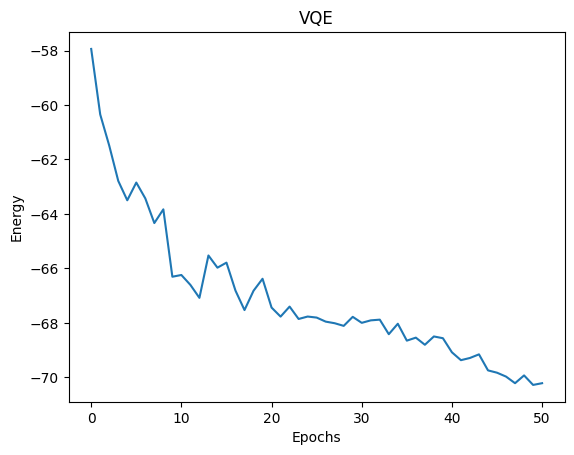

In [11]:
cudaq.set_target('nvidia')
start_time = timeit.default_timer()
result = minimize(cost,
                  x0,
                  method='COBYLA',
                  callback=callback,
                  options={'maxiter': 50})
end_time = timeit.default_timer()

print('UCCSD-VQE energy =  ', result.fun)
print('Total number of qubits = ', qubit_count)
print('Total number of parameters = ', parameter_count)
print('Total number of terms in the spin hamiltonian = ',
      spin_ham.get_term_count())
print('Total elapsed time (s) = ', end_time - start_time)

plt.plot(exp_vals)
plt.xlabel('Epochs')
plt.ylabel('Energy')
plt.title('VQE')
plt.show()

The result is an estimate of the groundstate energy of water.


In the above example, we included all the orbitals and electrons in the calculation. Often people will choose an active space for quantum chemistry calculations, where a subset of molecular orbitals (MOs) and electrons will be used while solving the Schrödinger equation. Most of the interesting chemistry can be modeled by restricting simulations to the highest energy occupied molecular orbitals and lowest energy unoccupied molecular orbitals. This is done to reduce computational cost while retaining the essential physics and chemistry of the problem. Using an active space means you can run VQE for the same molecule using fewer qubits and a more shallow circuit.

<table><tr>
<td> <img src="chemistry2_SC24.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

The molecule is defined the same way, expect for you now include variables nele_cas and norb_cas to define the active space:

In [12]:
geometry = [('O', (0.1173, 0.0, 0.0)), ('H', (-0.4691, 0.7570, 0.0)),
            ('H', (-0.4691, -0.7570, 0.0))]
basis = 'sto3g'
multiplicity = 1
charge = 0
ncore = 3
nele_cas, norb_cas = (4, 3)

molecule = openfermionpyscf.run_pyscf(
    openfermion.MolecularData(geometry, basis, multiplicity, charge))

The Hamiltonian is now constrcuted with the same steps, but only uses the active space.

In [13]:
molecular_hamiltonian = molecule.get_molecular_hamiltonian(
    occupied_indices=range(ncore),
    active_indices=range(ncore, ncore + norb_cas))

fermion_hamiltonian = get_fermion_operator(molecular_hamiltonian)

qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)

spin_ham = cudaq.SpinOperator(qubit_hamiltonian)

/tmp/ipykernel_1277046/1900341958.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  spin_ham = cudaq.SpinOperator(qubit_hamiltonian)


Similarly, the kernel is defined only by the orbitals and electrons in the active space meaning we only need to optimize 8 parameters now.

In [15]:
electron_count = nele_cas
qubit_count = 2 * norb_cas


@cudaq.kernel
def kernel(qubit_num: int, electron_num: int, thetas: list[float]):
    qubits = cudaq.qvector(qubit_num)

    for i in range(electron_num):
        x(qubits[i])

    cudaq.kernels.uccsd(qubits, thetas, electron_num, qubit_num)


parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count,
                                                     qubit_count)

print(qubit_count)
print(parameter_count)

6
8


In [16]:
def cost(theta):

    exp_val = cudaq.observe(kernel, spin_ham, qubit_count, electron_count,
                            theta).expectation()
    thetas = theta
    return exp_val


exp_vals = []


def callback(xk):
    exp_vals.append(cost(xk))


# Initial variational parameters.
np.random.seed(42)
x0 = np.random.normal(0, 1, parameter_count)

UCCSD-VQE energy =   -74.96333248875091
Total number of qubits =  6
Total number of parameters =  8
Total number of terms in the spin hamiltonian =  62
Total elapsed time (s) =  2.506197581999004


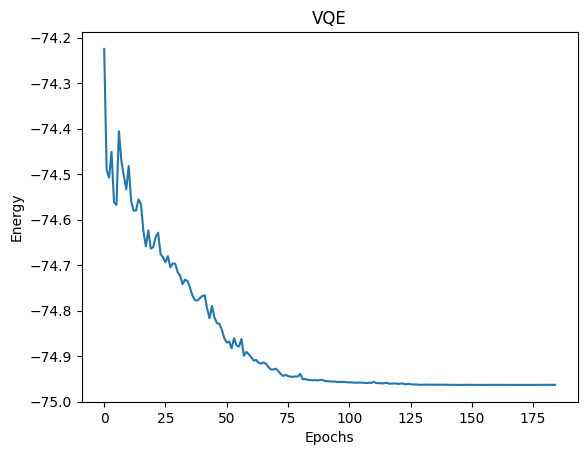

In [17]:
cudaq.set_target("nvidia")

start_time = timeit.default_timer()
result = minimize(cost,
                  x0,
                  method='COBYLA',
                  callback=callback,
                  options={'maxiter': 500})
end_time = timeit.default_timer()

print('UCCSD-VQE energy =  ', result.fun)
print('Total number of qubits = ', qubit_count)
print('Total number of parameters = ', parameter_count)
print('Total number of terms in the spin hamiltonian = ',
      spin_ham.get_term_count())
print('Total elapsed time (s) = ', end_time - start_time)

plt.plot(exp_vals)
plt.xlabel('Epochs')
plt.ylabel('Energy')
plt.title('VQE')
plt.show()

Note that the calculation occurs much faster now. 

Please see this part of the CUDA-Q docs for additional details (https://nvidia.github.io/cuda-quantum/latest/applications/python/vqe_advanced.html), and where much of this material was borrowed.

The above can seem like a lot for solving one molecular system! We have developed a library, called HamLib, to simplify many of the steps above. The dataset is freely available online and contains problem sizes ranging from 2 to 1000 qubits. HamLib includes problem instances of the Heisenberg model, Fermi-Hubbard model, Bose-Hubbard model, molecular electronic structure, molecular vibrational structure, MaxCut, Max-k-SAT, Max-k-Cut, QMaxCut, and the traveling salesperson problem. The goals of this effort are (a) to save researchers time by eliminating the need to prepare problem instances and map them to qubit representations, (b) to allow for more thorough tests of new algorithms and hardware, and (c) to allow for reproducibility and standardization across research studies.

<table><tr>
<td> <img src="chemistry3_SC24.png" alt="Drawing" style="width: 800px;"/> </td>
</tr></table>


<table><tr>
<td> <img src="chemistry5_SC24.png" alt="Drawing" style="width: 800px;"/> </td>
</tr></table>


The dataset can be found on NERSC servers at https://portal.nersc.gov/cfs/m888/dcamps/hamlib/. The paper descibring the dataset and how to extract the Hamiltonians can be found here: https://arxiv.org/abs/2306.13126